In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from cmaes import CMA
from scipy.ndimage import gaussian_filter, sobel, zoom
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
from scipy.spatial.distance import cdist
from tqdm import tqdm
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
from matplotlib.patches import Rectangle
from matplotlib.patches import Ellipse
from matplotlib.lines import Line2D

## Load the dataset ##

In [ ]:
def load_dataset(filename="dataset.csv"):
    """Load dataset from a CSV file and return it as NumPy arrays."""
    try:
        # Read the CSV using pandas
        df = pd.read_csv(filename)

        # Extract the features (x, y) and labels
        X = df[['x', 'y']].values
        y = df['label'].values

        print(f"Dataset loaded from {filename}")
        return X, y
    except FileNotFoundError:
        print(f"File {filename} not found. Make sure the file exists.")
        return None, None

# Example usage
X_loaded, y_loaded = load_dataset("eiox.csv")

Dataset loaded from eiox.csv


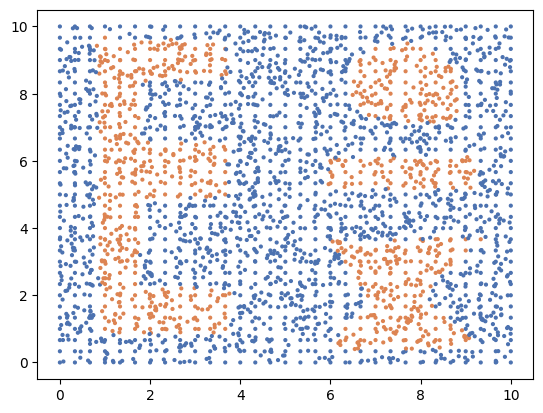

In [ ]:
%matplotlib inline

_colors=[(0.298, 0.447, 0.690),(0.867, 0.518, 0.322)]
plt.scatter(X_loaded[:,0], X_loaded[:, 1], c=[_colors[int(i)] for i in y_loaded], s=4)
plt.show()

## Train classification Model ##

In [ ]:
# Define a simple neural network with PyTorch
class SimpleNN(nn.Module):
    def __init__(self, n_classes = 2, device="cpu"):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(2, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, n_classes)
        self.device = device
        self.to(self.device)  # move model to device

    def forward(self, x):
        x = x.to(self.device)  # ensure input is on same device
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def predict_probas(self, x):
        if isinstance(x, np.ndarray):
            x = torch.tensor(x, dtype=torch.float32)
        x = x.to(self.device)  # ensure input is on same device
        with torch.no_grad():
            p = self.forward(x)
            p = torch.softmax(p, dim=-1)
        return p.cpu()  # always return results on CPU

    def predict(self, x):
        p = self.predict_probas(x)
        return p.argmax(1).detach()


def train_model(X_train, y_train, X_val, y_val, epochs=200, learning_rate=0.001, n_classes = 2):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    model = SimpleNN(device=device, n_classes = n_classes).to(device)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()

    dataset = TensorDataset(X_train_tensor, y_train_tensor)
    loader = DataLoader(dataset, batch_size=128, shuffle=True)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0.0

        for batch_x, batch_y in loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = loss_fn(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item() * batch_x.size(0)

        # Average training loss
        epoch_train_loss /= len(X_train)
        train_losses.append(epoch_train_loss)

        # Validation loss
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = loss_fn(val_outputs, y_val_tensor).item()
            val_losses.append(val_loss)

        if epoch % 50 == 0:
            print(f'Epoch {epoch}/{epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {val_loss:.4f}')

    print(f'Final Epoch {epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')
    return model, train_losses, val_losses


In [ ]:
# Split into train + val first, then extract test
X_temp, X_test, y_temp, y_test = train_test_split(X_loaded, y_loaded, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)  # 72% train, 18% val, 10% test

# Standardize using training set
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_loaded_scaled = scaler.transform(X_loaded)




Using device: cpu
Epoch 0/1000, Train Loss: 0.6466, Val Loss: 0.6155
Epoch 50/1000, Train Loss: 0.2387, Val Loss: 0.2540
Epoch 100/1000, Train Loss: 0.1386, Val Loss: 0.1639
Epoch 150/1000, Train Loss: 0.1040, Val Loss: 0.1205
Epoch 200/1000, Train Loss: 0.0759, Val Loss: 0.0969
Epoch 250/1000, Train Loss: 0.0631, Val Loss: 0.0897
Epoch 300/1000, Train Loss: 0.0584, Val Loss: 0.0791
Epoch 350/1000, Train Loss: 0.0489, Val Loss: 0.0828
Epoch 400/1000, Train Loss: 0.0413, Val Loss: 0.0695
Epoch 450/1000, Train Loss: 0.0445, Val Loss: 0.0637
Epoch 500/1000, Train Loss: 0.0332, Val Loss: 0.0623
Epoch 550/1000, Train Loss: 0.0332, Val Loss: 0.0739
Epoch 600/1000, Train Loss: 0.0342, Val Loss: 0.0629
Epoch 650/1000, Train Loss: 0.0417, Val Loss: 0.0634
Epoch 700/1000, Train Loss: 0.0346, Val Loss: 0.0784
Epoch 750/1000, Train Loss: 0.0333, Val Loss: 0.0729
Epoch 800/1000, Train Loss: 0.0284, Val Loss: 0.0858
Epoch 850/1000, Train Loss: 0.0277, Val Loss: 0.0642
Epoch 900/1000, Train Loss: 0.0

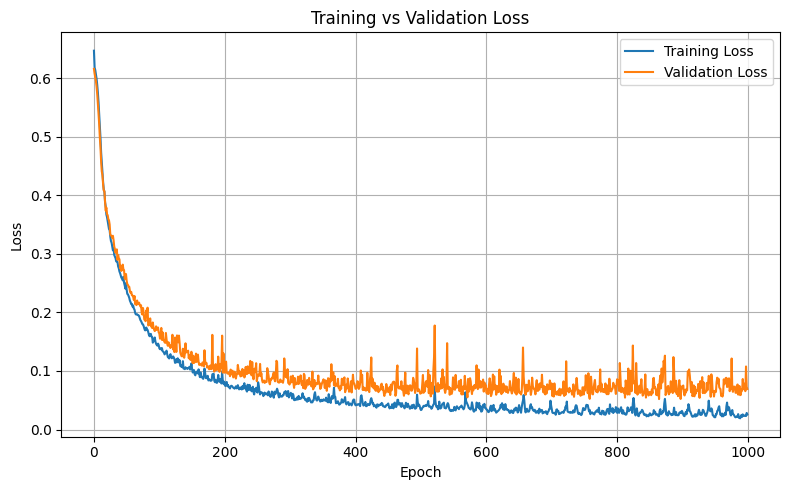

In [ ]:
# Train the model with validation tracking
model, train_losses, val_losses = train_model(X_train, y_train, X_val, y_val, epochs=1000)

# Plot the losses
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
accuracy = lambda x, y: np.mean(model.predict(x).numpy() == y)
print("train accuracy: ", accuracy(X_train, y_train))
print("test accuracy: ", accuracy(X_test, y_test))

train accuracy:  0.992961051149695
test accuracy:  0.9696969696969697


In [ ]:
x_min, y_min = X_loaded_scaled.min(axis=0)
x_max, y_max = X_loaded_scaled.max(axis=0)
num_points = 1000

# Create linspace for x and y dimensions
x_grid = np.linspace(x_min, x_max, num_points)
y_grid = np.linspace(y_min, y_max, num_points)

# Create a meshgrid (grid of points in the x-y plane)
xx, yy = np.meshgrid(x_grid, y_grid)
grid_points = np.c_[xx.ravel(), yy.ravel()]

[0 1]


(1000000,)

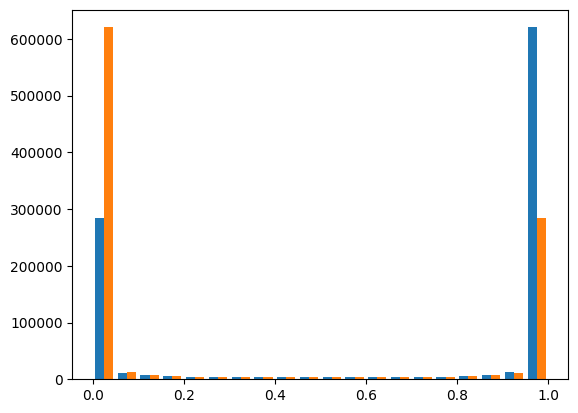

In [ ]:
grid_probas = model.predict_probas(grid_points).detach().numpy()

%matplotlib inline
plt.hist(grid_probas, 20)
grid_labels = model.predict(grid_points)
print(np.unique(grid_labels))
grid_alphas = grid_probas[np.arange(len(grid_probas)), np.expand_dims(grid_labels, 0)].squeeze()
grid_alphas.shape

In [ ]:
grid_labels = model.predict(grid_points)
grid_labels_reshaped = grid_labels.reshape(num_points, num_points)
grid_alphas_reshaped = grid_alphas.reshape(num_points, num_points)
colors = np.zeros((num_points, num_points, 4))
colors[grid_labels_reshaped == 0] = [0.298, 0.447, 0.690, 1]  # Red for label 0
colors[grid_labels_reshaped == 1] = [0.867, 0.518, 0.322, 1]  # Blue for label 1

colors[..., -1] = 2 * (grid_alphas_reshaped - np.min(grid_alphas_reshaped))
smoothed_colors = gaussian_filter(colors, sigma=[1, 1, 0])

colors normalized to min probability, ie white == 0.500012993812561 'certainty';


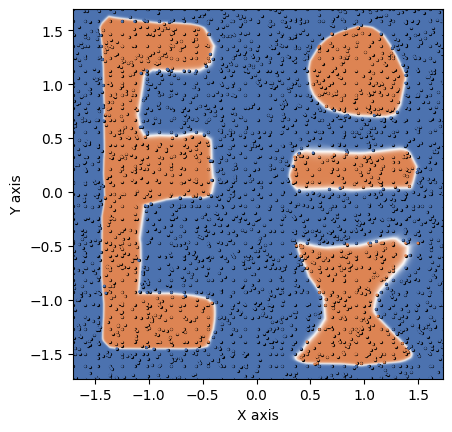

In [ ]:
fig, ax = plt.subplots()
ax.imshow(smoothed_colors, extent=(x_min, x_max, y_min, y_max), origin='lower')

# plot full dataset with original label; add small black outline
ax.scatter(X_loaded_scaled[:, 0], X_loaded_scaled[:, 1], s=1.75, c='black')
ax.scatter(X_loaded_scaled[:, 0], X_loaded_scaled[:, 1], s=1, c=[_colors[int(i)] for i in y_loaded])

plt.xlabel('X axis')
plt.ylabel('Y axis')
print(f"colors normalized to min probability, ie white == {np.min(grid_alphas_reshaped)} 'certainty';")

plt.show()

# Finding points on decision boundary #

## 1. CMA-ES ##

In [ ]:
def _cma_cost_function_uniform_output(inference_fn, x, target):
    y = inference_fn(x).detach().numpy()
    loss = np.sum(np.abs(y - target), axis=1)
    return loss

def is_numeric(value):
    return isinstance(value, (int, float, complex)) and not isinstance(value, bool)

def cmaes_baseline(inference_fn, n_dims, n_classes, initial_baseline=0., std=0.5, n_generations=500,
                   criterion=_cma_cost_function_uniform_output, threshold=None):
    if threshold is None:  # magic numbers
        if n_classes <= 3:
            threshold = 1e-2
        else:
            threshold = 2e-2*n_classes

    # given a starting vector, find a vector that
    # confuses model as best as possible.
    if is_numeric(initial_baseline):
        initial_baseline = np.array([initial_baseline]*n_dims)
    b = np.array(initial_baseline)
    population_size = int(4 * (4 + np.floor(3 * np.log(n_dims))))  #4 + math.floor(3 * math.log(n_dim)) # default population size
    optimizer = CMA(mean=b, sigma=std, population_size=population_size)

    # TODO: it considers uniformity as target by 1/ n_classes. That only works for binary classification!
    uniform_target = np.ones((1, n_classes)) * (1 / n_classes)
    _criterion = lambda x: criterion(inference_fn, x, uniform_target)
    best_score, solution, update_generation = np.inf, None, -1
    for generation in range(n_generations):
        batch = []
        for _ in range(optimizer.population_size):
            c = optimizer.ask()
            batch.append(c)
        torch_batch = torch.tensor(np.vstack(batch), dtype=torch.float)
        fitness = _criterion(torch_batch)

        tell_data = list(zip(batch, fitness.astype(np.float64)))
        optimizer.tell(tell_data)

        if best_score > np.min(fitness):
            update_generation = generation
            best_score = np.min(fitness)
            solution = batch[np.argmin(fitness)]

        if (generation - update_generation) > 0.1*n_generations:
            # haven't updated for more than 10% of generations
            break

        if np.min(fitness) <= threshold:
            break

        if optimizer.should_stop():
            break

    prediction = inference_fn(torch.tensor(solution, dtype=torch.float).unsqueeze(0)).detach().cpu().numpy()
    return solution, prediction

In [ ]:
def get_uniformity_score(y):
      y = np.atleast_2d(y)
      # 1. Sort descending
      sorted_probs = np.sort(y, axis=1)[:, ::-1]
      # 2. Take top 2 and renormalize
      top2 = sorted_probs[:, :2]
      top2_renorm = top2 / np.sum(top2, axis=1, keepdims=True)
      # 3. Compute uniformity loss vs target [0.5, 0.5]
      target = np.ones_like(top2_renorm) * 0.5
      uniformity_loss = np.sum(np.abs(top2_renorm - target), axis=1)
      return uniformity_loss[0]

In [ ]:
def combined_cma_cost(inference_fn, x, original_point, n_classes, alpha=0.5, beta=0.5):
    """
    Cost = α * distance + β * uniformity_score
    """
    x = x.detach().numpy() if isinstance(x, torch.Tensor) else x
    y = inference_fn(torch.tensor(x, dtype=torch.float)).detach().cpu().numpy()

    # Uniformity loss (closer to 1/n_classes is better)
    # TODO: as above, this part needs to be updated for multi-class classification
    sorted_probs = np.sort(y, axis=1)[:, ::-1]
    top2 = sorted_probs[:, :2]
    # Re-normalize so they sum to 1
    top2_renorm = top2 / np.sum(top2, axis=1, keepdims=True)
    # Target = [0.5, 0.5]
    target = np.ones_like(top2_renorm) * 0.5
    uniformity_loss = np.sum(np.abs(top2_renorm - target), axis=1)


    # Distance from original point
    if original_point.ndim == 1:
        original_point = original_point[np.newaxis, :]
    distances = np.linalg.norm(x - original_point, axis=1)

    # Total loss
    return alpha * distances + beta * uniformity_loss

# 2. FGSM #

In [ ]:
def fgsm_decision_boundary_point(model, original_point, n_classes=2, epsilon=0.01, n_steps=100, device='cpu'):
    """
    Use FGSM to iteratively perturb a point toward the decision boundary.

    Args:
        model: A PyTorch model (must return logits or probabilities).
        original_point: 1D numpy array of shape (n_features,) – starting point.
        n_classes: Number of output classes.
        epsilon: Step size for FGSM.
        n_steps: Number of FGSM steps to take.
        device: 'cpu' or 'cuda'

    Returns:
        A numpy array representing the perturbed point near the decision boundary.
    """
    model.eval()
    original_point = torch.tensor(original_point, dtype=torch.float32, device=device).unsqueeze(0)
    x = original_point.clone().detach().requires_grad_(True)

    loss_fn = nn.CrossEntropyLoss()

    # Use the model's current prediction as the label
    with torch.no_grad():
        pred = model(original_point)
        label = torch.argmax(pred, dim=1)

    for _ in range(n_steps):
        if x.grad is not None:
            x.grad.zero_()

        logits = model(x)
        loss = loss_fn(logits, label)
        loss.backward()

        # FGSM update step
        x = x + epsilon * x.grad.sign()
        x = x.detach().requires_grad_()

        # Optional early stopping: check if prediction flips
        with torch.no_grad():
            new_pred = torch.argmax(model(x), dim=1)
            if new_pred.item() != label.item():
                break

    return x.squeeze().detach().cpu().numpy()


## Comparison: FGSM vs CMA-ES ##

In [ ]:
def run_analysis(model, n_dims, n_classes, original_point, alpha, beta):
    inference_fn = lambda x: model.predict_probas(x)

    # Run CMA-ES
    solution, pred = cmaes_baseline(
        inference_fn=inference_fn,
        n_dims=n_dims,
        n_classes=n_classes,
        initial_baseline=original_point,
        criterion=lambda f, x, _: combined_cma_cost(f, x, original_point, n_classes, alpha, beta),
        n_generations=300
    )

    # Run FGSM
    fgsm_solution = fgsm_decision_boundary_point(
        model=model,
        original_point=original_point,
        n_classes=n_classes,
        epsilon=0.01,
        n_steps=100
    )

    # Interpolation for CMA-ES path
    steps = 50
    alphas = torch.linspace(0, 1, steps=steps)
    cma_baseline_tensor = torch.tensor(solution, dtype=torch.float32)
    sample_tensor = torch.tensor(original_point, dtype=torch.float32)
    interpolated_cma = torch.stack([
        cma_baseline_tensor + alpha * (sample_tensor - cma_baseline_tensor)
        for alpha in alphas
    ]).numpy()

    # Interpolation for FGSM path
    fgsm_tensor = torch.tensor(fgsm_solution, dtype=torch.float32)
    interpolated_fgsm = torch.stack([
        fgsm_tensor + alpha * (sample_tensor - fgsm_tensor)
        for alpha in alphas
    ]).numpy()

    # Plotting
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(smoothed_colors, extent=(x_min, x_max, y_min, y_max), origin='lower')

    # Paths
    ax.plot(interpolated_cma[:, 0], interpolated_cma[:, 1], c='purple', lw=2, label='CMA-ES Path')
    ax.plot(interpolated_fgsm[:, 0], interpolated_fgsm[:, 1], c='orange', lw=2, label='FGSM Path')

    # Points
    ax.scatter(original_point[0], original_point[1], c='red', s=60, label='Sample Point', edgecolors='k', marker='*', zorder=3)
    ax.scatter(solution[0], solution[1], c='blue', s=60, label='CMA-ES Baseline', edgecolors='k', zorder=3)
    ax.scatter(fgsm_solution[0], fgsm_solution[1], c='orange', s=60, label='FGSM Baseline', edgecolors='k', marker='^', zorder=3)

    # Labels
    ax.legend()
    ax.set_xlabel('Feature 1 (x)')
    ax.set_ylabel('Feature 2 (y)')
    ax.set_title("Integrated Paths from CMA-ES and FGSM to Sample")
    plt.show()


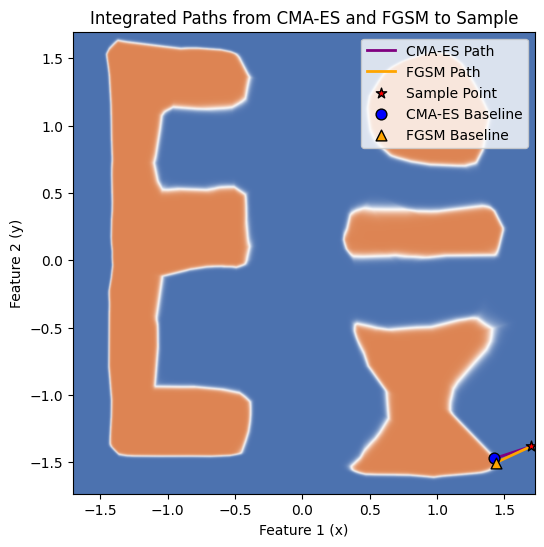

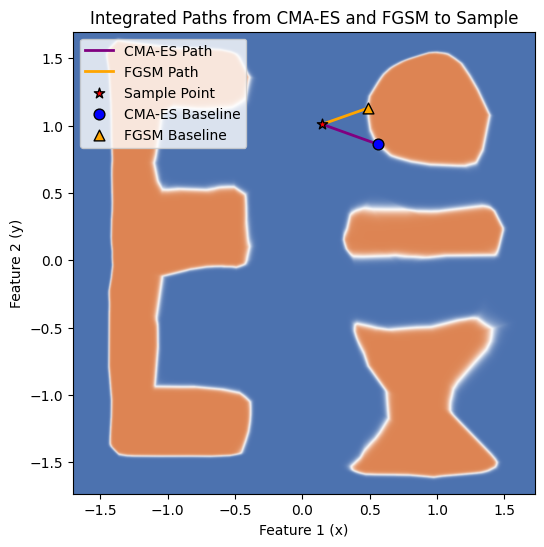

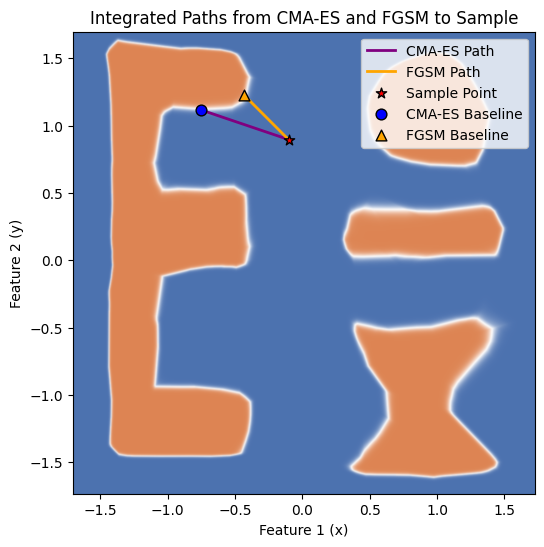

In [ ]:
n_dims = X_test.shape[1]
n_classes = 2
n_test = 3
# Test for a couple of points
test_point_indexes = [np.random.randint(0, len(X_test)) for _ in range(n_test)]
for index in test_point_indexes:
    run_analysis(model, n_dims, n_classes, original_point = X_test[index], alpha = 0.5, beta = 0.5)


### Refine the found decision boundary point ###

In [ ]:
def refine_point(model, initial_point, cost_fn, n_steps=50, epsilon=1e-2):
    point = initial_point.copy()
    for _ in range(n_steps):
        # Try small perturbations in random directions
        directions = np.random.randn(10, len(point)) * epsilon
        candidates = point + directions
        scores = cost_fn(model, torch.tensor(candidates, dtype=torch.float32))
        best_idx = np.argmin(scores)
        if scores[best_idx] < cost_fn(model, torch.tensor(point[None, :], dtype=torch.float32)):
            point = candidates[best_idx]
    return point


In [ ]:
def refine_point_gradient(model, initial_point, original_point, n_classes, alpha=0.5, beta=0.5,
                          n_steps=50, lr=1e-2):
    point = torch.tensor(initial_point, dtype=torch.float32, requires_grad=True)
    original_point = torch.tensor(original_point, dtype=torch.float32)

    optimizer = torch.optim.Adam([point], lr=lr)

    for _ in range(n_steps):
        optimizer.zero_grad()

        # Model prediction
        preds = model(point.unsqueeze(0))  # shape: (1, n_classes)

        # Uniformity loss (low confidence)
        # TODO: Update uniformity loss to accommodate multi-classes
        target = torch.ones_like(preds) * (1.0 / n_classes)
        uniformity_loss = torch.sum(torch.abs(preds - target))

        # Distance from original point
        distance = torch.norm(point - original_point)

        # Combined loss
        loss = alpha * distance + beta * uniformity_loss

        loss.backward()
        optimizer.step()

    return point.detach().numpy()


#### Example usage on decision boundary point by CMA-ES ####

In [ ]:
# Pick a random sample point from test set to use as original_point
original_point = X_test[np.random.randint(0, len(X_test))]

cma_solution, pred = cmaes_baseline(
    inference_fn=model,
    n_dims=n_dims,
    n_classes=n_classes,
    initial_baseline=original_point,
    criterion=lambda f, x, _: combined_cma_cost(f, x, original_point, n_classes),
    n_generations=300
)

initial_point = cma_solution  # or any point from FGSM etc.
refined_point = refine_point(
    model=model,
    initial_point=initial_point,
    cost_fn=lambda m, x: combined_cma_cost(m, x, original_point=original_point, n_classes=2)
)
refined_point_gradient = refine_point_gradient(
    model=model,
    initial_point=initial_point,
    original_point=original_point,
    n_classes=n_classes,
    n_steps=100,
    lr=0.01
)

print("Original CMA Point:", initial_point)
print("Refined Point:", refined_point)
print("Refined Point (gradient):", refined_point_gradient)

Original CMA Point: [ 1.3423675  -1.38628329]
Refined Point: [ 1.43931041 -1.49818028]
Refined Point (gradient): [ 1.4198215 -1.4667193]


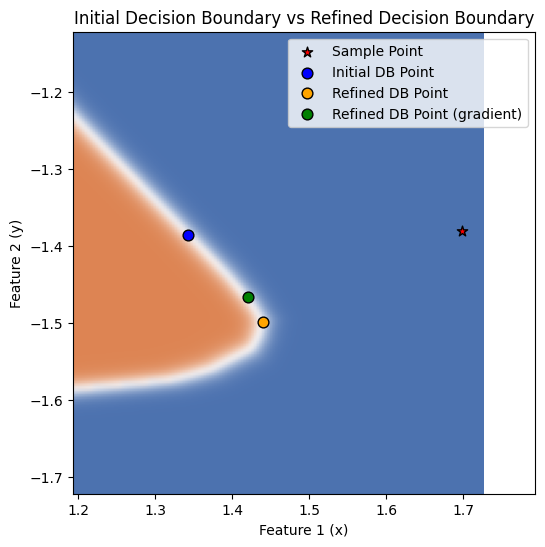

In [ ]:
# Check if variables are defined from previous cell
if 'original_point' not in locals():
    original_point = X_test[np.random.randint(0, len(X_test))]
    print("Note: original_point was not defined, using a random test point")

fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(smoothed_colors, extent=(x_min, x_max, y_min, y_max), origin='lower')


# Points
ax.scatter(original_point[0], original_point[1], c='red', s=60, label='Sample Point', edgecolors='k', marker='*', zorder=3)
ax.scatter(initial_point[0], initial_point[1], c='blue', s=60, label='Initial DB Point', edgecolors='k', zorder=3)
ax.scatter(refined_point[0], refined_point[1], c='orange', s=60, label='Refined DB Point', edgecolors='k',  zorder=3)
ax.scatter(refined_point_gradient[0], refined_point_gradient[1], c='green', s=60, label='Refined DB Point (gradient)', edgecolors='k',  zorder=3)

all_points = np.vstack([original_point, initial_point, refined_point])
x_center, y_center = np.mean(all_points, axis=0)
zoom_radius = 0.3  # You can increase this to zoom out a bit

ax.set_xlim(x_center - zoom_radius, x_center + zoom_radius)
ax.set_ylim(y_center - zoom_radius, y_center + zoom_radius)

# Labels
ax.legend()
ax.set_xlabel('Feature 1 (x)')
ax.set_ylabel('Feature 2 (y)')
ax.set_title("Initial Decision Boundary vs Refined Decision Boundary")
plt.show()

## Find ground truth point on decision boundary using pixel-method

In [ ]:

def find_closest_boundary(start_point, smoothed_colors, x_min, x_max, y_min, y_max):
    # compute gradient magnitude
    if smoothed_colors.ndim == 3:
        # RGB / color image
        grad = np.zeros(smoothed_colors.shape[:2])
        for c in range(smoothed_colors.shape[2]):
            grad_x = sobel(smoothed_colors[..., c], axis=1)
            grad_y = sobel(smoothed_colors[..., c], axis=0)
            grad += np.sqrt(grad_x**2 + grad_y**2)
    else:
        # grayscale
        grad_x = sobel(smoothed_colors, axis=1)
        grad_y = sobel(smoothed_colors, axis=0)
        grad = np.sqrt(grad_x**2 + grad_y**2)

    # normalize gradient
    grad /= grad.max()

    # threshold to detect boundary pixels
    threshold = 0.05
    boundary_pixels = np.argwhere(grad > threshold)

    # map start_point to pixel coordinates
    ny, nx = smoothed_colors.shape[:2]
    px = int((start_point[0] - x_min) / (x_max - x_min) * (nx - 1))
    py = int((start_point[1] - y_min) / (y_max - y_min) * (ny - 1))

    # compute distance to all boundary pixels
    dists = np.linalg.norm(boundary_pixels - np.array([py, px]), axis=1)
    closest_idx = np.argmin(dists)
    closest_pixel = boundary_pixels[closest_idx]

    # map pixel back to xy coordinates
    closest_x = x_min + closest_pixel[1] / (nx - 1) * (x_max - x_min)
    closest_y = y_min + closest_pixel[0] / (ny - 1) * (y_max - y_min)

    return np.array([closest_x, closest_y])


### Example for ground-truth boundary finding method

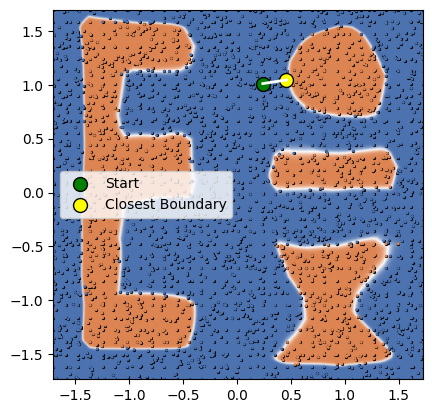

In [ ]:
fig, ax = plt.subplots()
ax.imshow(smoothed_colors, extent=(x_min, x_max, y_min, y_max), origin='lower')

# pick random start
idx = np.random.randint(0, X_loaded_scaled.shape[0])
start_point = X_loaded_scaled[idx]

closest_boundary = find_closest_boundary(start_point, smoothed_colors, x_min, x_max, y_min, y_max)

ax.scatter(X_loaded_scaled[:, 0], X_loaded_scaled[:, 1], s=1.75, c='black')
ax.scatter(X_loaded_scaled[:, 0], X_loaded_scaled[:, 1], s=1, c=[_colors[int(i)] for i in y_loaded])

ax.scatter(start_point[0], start_point[1], c='green', s=100, edgecolors='black', label='Start')
ax.scatter(closest_boundary[0], closest_boundary[1], c='yellow', s=100, edgecolors='black', label='Closest Boundary')
ax.plot([start_point[0], closest_boundary[0]], [start_point[1], closest_boundary[1]], c='white', linestyle='-', linewidth=2)

ax.legend()
plt.show()


In [ ]:
n_samples = 150
distances_cmaes = []
distances_fgsm = []
uniformity_cmaes = []
uniformity_fgsm = []

for _ in range(n_samples):
    # --- 1. Generate a random sample ---
    idx = np.random.randint(0, X_loaded_scaled.shape[0])
    original_point = X_loaded_scaled[idx]

    # --- 2. Find ground truth boundary ---
    ground_truth = find_closest_boundary(
        original_point, smoothed_colors, x_min, x_max, y_min, y_max
    )

    # --- 3. CMA-ES solution ---
    solution_cmaes, pred_cmaes = cmaes_baseline(
        inference_fn=inference_fn,
        n_dims=original_point.shape[0],
        n_classes=n_classes,
        initial_baseline=original_point,
        criterion=lambda f, x, _: combined_cma_cost(f, x, original_point, n_classes),
        n_generations=300
    )

    # --- 4. FGSM solution ---
    fgsm_solution = fgsm_decision_boundary_point(
        model=model,
        original_point=original_point,
        n_classes=n_classes,
        epsilon=0.01,
        n_steps=100
    )

    # --- 5. Compute Euclidean distances to ground truth ---
    dist_cmaes = np.linalg.norm(solution_cmaes - ground_truth)
    dist_fgsm = np.linalg.norm(fgsm_solution - ground_truth)
    distances_cmaes.append(dist_cmaes)
    distances_fgsm.append(dist_fgsm)

    # --- 6. Compute uniformity scores ---
    # CMA-ES
    y_cmaes = inference_fn(torch.tensor(solution_cmaes, dtype=torch.float)).detach().cpu().numpy()
    uniformity_cmaes.append(get_uniformity_score(y_cmaes))

    # FGSM
    y_fgsm = inference_fn(torch.tensor(fgsm_solution, dtype=torch.float)).detach().cpu().numpy()
    uniformity_fgsm.append(get_uniformity_score(y_fgsm))

# --- Summary ---
print("Average Euclidean distance to ground truth:")
print("CMA-ES:", np.mean(distances_cmaes))
print("FGSM:", np.mean(distances_fgsm))

print("Standart Deviation Euclidean distance to ground truth:")
print("CMA-ES:", np.std(distances_cmaes))
print("FGSM:", np.std(distances_fgsm))

print("Average uniformity loss:")
print("CMA-ES:", np.mean(uniformity_cmaes))
print("FGSM:", np.mean(uniformity_fgsm))

print("Standart Deviation uniformity loss:")
print("CMA-ES:", np.std(uniformity_cmaes))
print("FGSM:", np.std(uniformity_fgsm))


Average Euclidean distance to ground truth:
CMA-ES: 0.11871327568491057
FGSM: 0.1278734345585283
Standart Deviation Euclidean distance to ground truth:
CMA-ES: 0.16391063777582715
FGSM: 0.15739756874633323
Average uniformity loss:
CMA-ES: 0.13583723
FGSM: 0.30711892
Standart Deviation uniformity loss:
CMA-ES: 0.27678075
FGSM: 0.21423596


Starting CMAES stability analysis...
FGSM will be run once per sample (deterministic algorithm)
CMAES will be run multiple times to assess stability...


Running stability analysis: 100%|██████████| 315/315 [00:25<00:00, 12.45it/s]


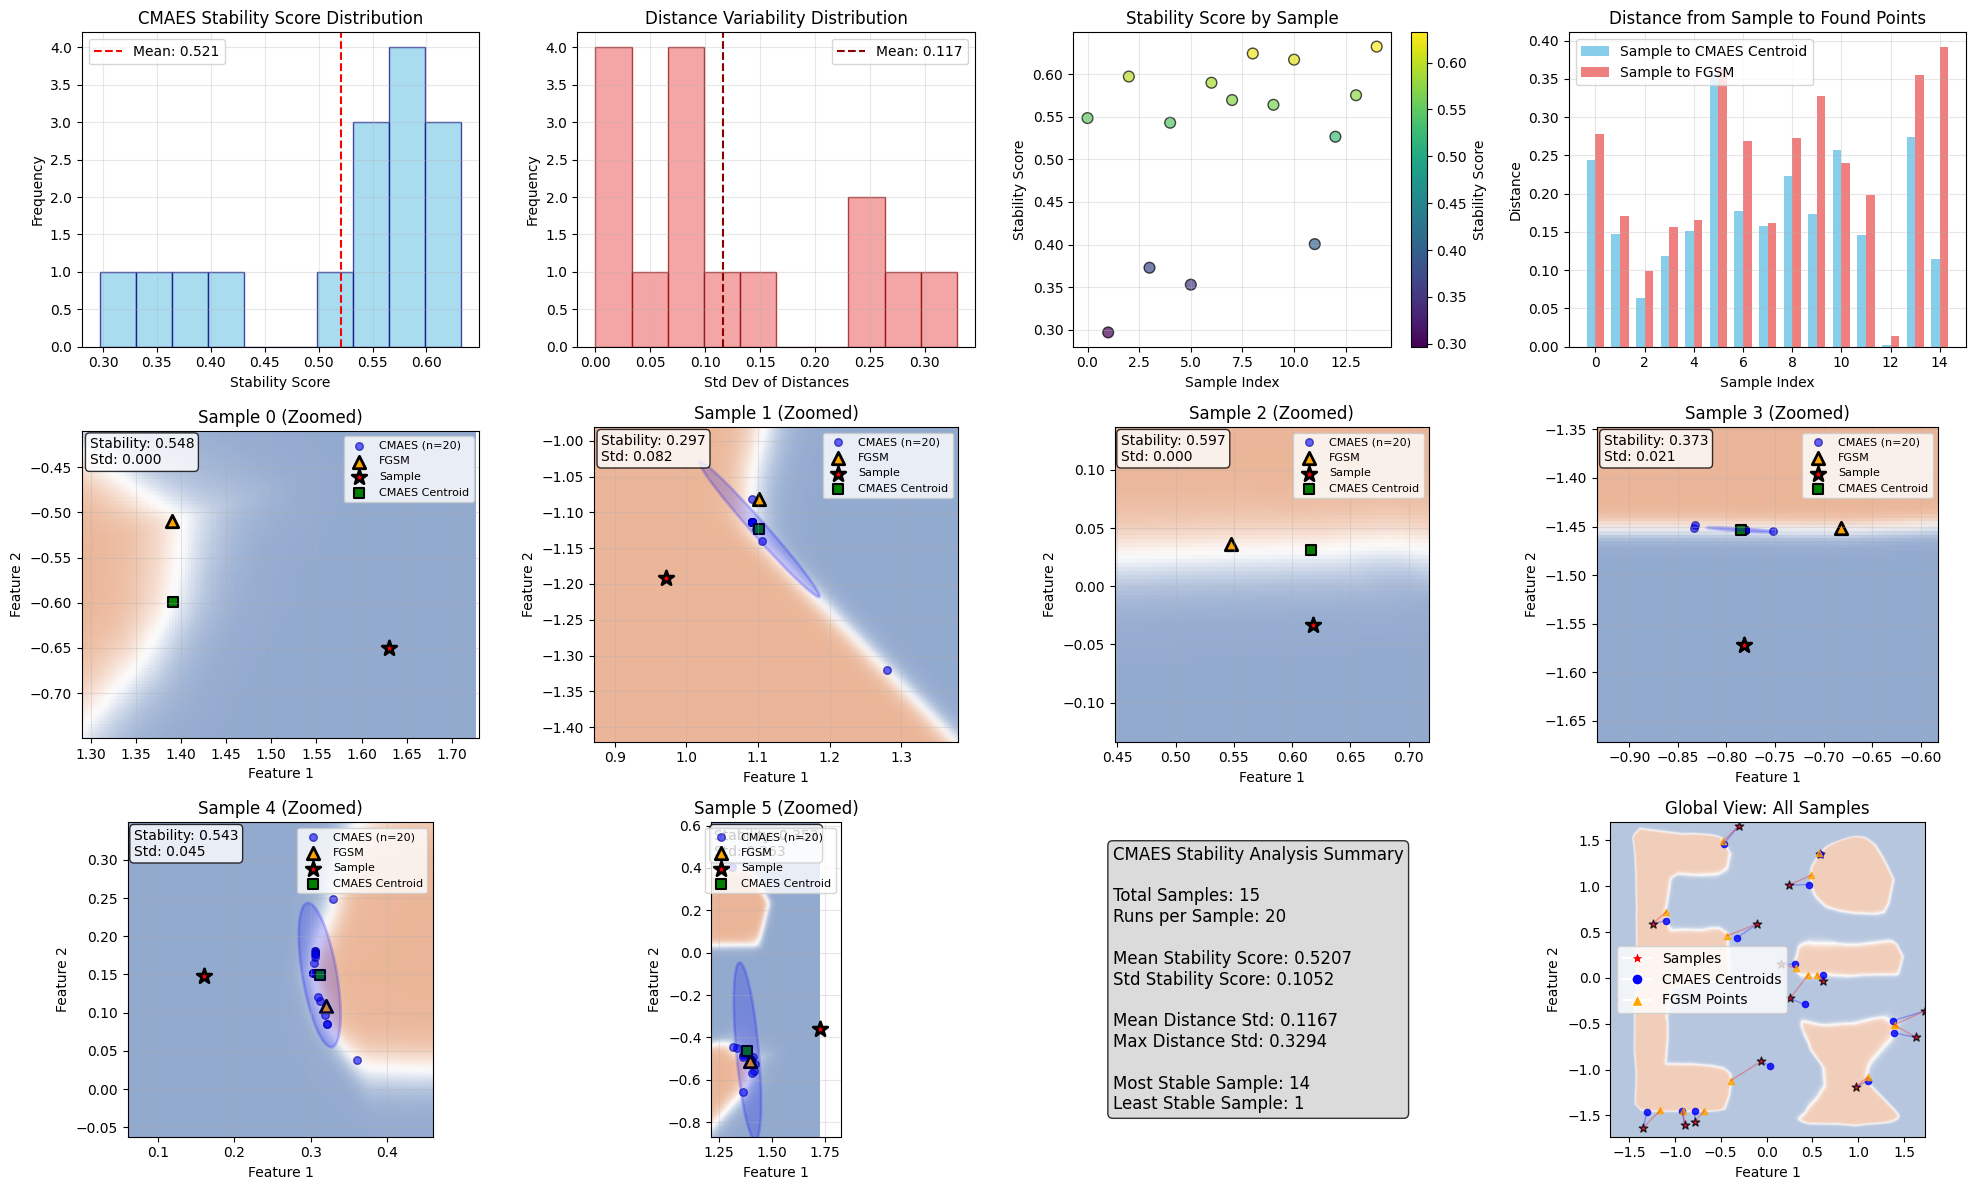


CMAES STABILITY ANALYSIS REPORT

Analysis Configuration:
  - Number of samples tested: 15
  - Number of CMAES runs per sample: 20
  - FGSM runs per sample: 1 (deterministic)

Overall CMAES Stability Metrics:
  - Mean stability score: 0.5207
  - Std stability score: 0.1052
  - Min stability score: 0.2970
  - Max stability score: 0.6322

Distance Variability:
  - Mean of std distances: 0.1167
  - Max std distance: 0.3294

Unstable samples (score < 0.415):
  - Sample 1: stability = 0.2970, std = 0.0825
  - Sample 3: stability = 0.3728, std = 0.0214
  - Sample 5: stability = 0.3530, std = 0.2629
  - Sample 11: stability = 0.4005, std = 0.0985

Distance Comparison (from original sample):
  - Mean distance to CMAES centroid: 0.1738
  - Mean distance to FGSM point: 0.2307


Sample-specific insights:

Sample 0:
  - Stability score: 0.5484
  - Distance std: 0.0000
  - CMAES spread: 0.0000
  - Spread ratio (max/min dist): 10516.27

Sample 1:
  - Stability score: 0.2970
  - Distance std: 0.0825


In [ ]:
def evaluate_cmaes_stability(model, X_test, n_samples=15, n_runs=20, cma_generations=200):
    """
    Evaluate the stability of CMAES in finding decision boundary points.
    FGSM is deterministic so we only run it once per sample.

    Args:
        model: trained PyTorch model
        X_test: test dataset
        n_samples: number of sample points to test
        n_runs: number of times to run CMAES per sample
        cma_generations: number of generations for CMAES

    Returns:
        results_dict: dictionary containing all results and metrics
    """

    # Randomly select sample points
    np.random.seed(None)  # Ensure different samples each run
    sample_indices = np.random.choice(len(X_test), n_samples, replace=False)
    sample_points = X_test[sample_indices]

    results = {
        'cmaes_points': [],      # List of arrays, each containing n_runs points
        'fgsm_points': [],       # Single point per sample
        'stability_scores': [],   # Stability score per sample
        'mean_distances': [],     # Mean pairwise distance
        'std_distances': [],      # Std of pairwise distances
        'centroids': []          # Centroid of CMAES points
    }

    # Progress tracking
    total_iterations = n_samples * (n_runs + 1)  # n_runs for CMAES + 1 for FGSM
    pbar = tqdm(total=total_iterations, desc="Running stability analysis")

    for i, sample in enumerate(sample_points):
        # Store results for this sample
        cmaes_results = []

        # Run CMAES multiple times
        for run in range(n_runs):
            try:
                # Run CMAES without fixed seed
                cma_point, _ = cmaes_baseline(
                    inference_fn=lambda x: model.predict_probas(x),
                    n_dims=sample.shape[0],
                    n_classes=2,
                    initial_baseline=sample,
                    std=0.5,
                    n_generations=cma_generations,
                    criterion=lambda f, x, _: combined_cma_cost(f, x, sample, 2, alpha=0.5, beta=0.5)
                )
                cmaes_results.append(cma_point)
            except Exception as e:
                print(f"CMAES failed for sample {i}, run {run}: {e}")
                cmaes_results.append(sample.copy())  # Fallback to original point
            pbar.update(1)

        # Run FGSM once (deterministic)
        try:
            fgsm_point = fgsm_decision_boundary_point(
                model=model,
                original_point=sample,
                n_classes=2,
                epsilon=0.01,
                n_steps=100
            )
        except Exception as e:
            print(f"FGSM failed for sample {i}: {e}")
            fgsm_point = sample.copy()  # Fallback to original point
        pbar.update(1)

        # Calculate stability metrics for CMAES
        cmaes_points_array = np.array(cmaes_results)

        # Calculate centroid
        centroid = np.mean(cmaes_points_array, axis=0)

        if len(cmaes_points_array) > 1:
            # Calculate pairwise distances
            distances = pdist(cmaes_points_array, metric='euclidean')
            mean_dist = np.mean(distances)
            std_dist = np.std(distances)
            # Stability score: inverse of coefficient of variation
            cv = std_dist / (mean_dist + 1e-8)
            stability_score = 1 / (1 + cv)
        else:
            mean_dist, std_dist, stability_score = 0, 0, 1

        results['cmaes_points'].append(cmaes_points_array)
        results['fgsm_points'].append(fgsm_point)
        results['mean_distances'].append(mean_dist)
        results['std_distances'].append(std_dist)
        results['stability_scores'].append(stability_score)
        results['centroids'].append(centroid)

    pbar.close()

    # Add sample points to results
    results['samples'] = sample_points
    results['sample_indices'] = sample_indices

    return results


def plot_cmaes_stability_detailed(results, model=None, smoothed_colors=None,
                                 x_min=None, x_max=None, y_min=None, y_max=None):
    """
    Create detailed visualizations focusing on CMAES stability with zoomed views
    """
    n_samples = len(results['samples'])
    n_display = min(6, n_samples)  # Display up to 6 samples

    fig = plt.figure(figsize=(20, 12))

    # 1. Overall stability metrics
    ax1 = plt.subplot(3, 4, 1)
    ax1.hist(results['stability_scores'], bins=10, color='skyblue', edgecolor='navy', alpha=0.7)
    ax1.axvline(np.mean(results['stability_scores']), color='red', linestyle='--',
               label=f'Mean: {np.mean(results['stability_scores']):.3f}')
    ax1.set_xlabel('Stability Score')
    ax1.set_ylabel('Frequency')
    ax1.set_title('CMAES Stability Score Distribution')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Standard deviation distribution
    ax2 = plt.subplot(3, 4, 2)
    ax2.hist(results['std_distances'], bins=10, color='lightcoral', edgecolor='darkred', alpha=0.7)
    ax2.axvline(np.mean(results['std_distances']), color='darkred', linestyle='--',
               label=f'Mean: {np.mean(results['std_distances']):.3f}')
    ax2.set_xlabel('Std Dev of Distances')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distance Variability Distribution')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. Stability vs Sample Index
    ax3 = plt.subplot(3, 4, 3)
    sample_idx = np.arange(len(results['stability_scores']))
    ax3.scatter(sample_idx, results['stability_scores'], s=60, alpha=0.7,
               c=results['stability_scores'], cmap='viridis', edgecolors='black')
    ax3.set_xlabel('Sample Index')
    ax3.set_ylabel('Stability Score')
    ax3.set_title('Stability Score by Sample')
    ax3.grid(True, alpha=0.3)

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap='viridis',
                               norm=plt.Normalize(vmin=min(results['stability_scores']),
                                                vmax=max(results['stability_scores'])))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax3)
    cbar.set_label('Stability Score')

    # 4. Distance from sample to centroids
    ax4 = plt.subplot(3, 4, 4)
    sample_to_centroid_dist = []
    sample_to_fgsm_dist = []
    for i in range(len(results['samples'])):
        sample = results['samples'][i]
        centroid = results['centroids'][i]
        fgsm = results['fgsm_points'][i]
        sample_to_centroid_dist.append(np.linalg.norm(sample - centroid))
        sample_to_fgsm_dist.append(np.linalg.norm(sample - fgsm))

    x = np.arange(len(sample_to_centroid_dist))
    width = 0.35
    ax4.bar(x - width/2, sample_to_centroid_dist, width, label='Sample to CMAES Centroid',
           color='skyblue')
    ax4.bar(x + width/2, sample_to_fgsm_dist, width, label='Sample to FGSM',
           color='lightcoral')
    ax4.set_xlabel('Sample Index')
    ax4.set_ylabel('Distance')
    ax4.set_title('Distance from Sample to Found Points')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    # 5-10. Individual sample visualizations with zoom
    for idx in range(n_display):
        ax = plt.subplot(3, 4, 5 + idx)

        # Background decision boundary
        if smoothed_colors is not None:
            ax.imshow(smoothed_colors, extent=(x_min, x_max, y_min, y_max),
                     origin='lower', alpha=0.6)

        # Get points
        sample = results['samples'][idx]
        cmaes_points = results['cmaes_points'][idx]
        fgsm_point = results['fgsm_points'][idx]
        centroid = results['centroids'][idx]

        # Plot all points first (for determining zoom)
        ax.scatter(cmaes_points[:, 0], cmaes_points[:, 1], c='blue', s=30,
                  alpha=0.6, label=f'CMAES (n={len(cmaes_points)})', edgecolors='darkblue')
        ax.scatter(fgsm_point[0], fgsm_point[1], c='orange', s=80,
                  marker='^', label='FGSM', edgecolors='black', linewidth=2)
        ax.scatter(sample[0], sample[1], c='red', s=120, marker='*',
                  label='Sample', edgecolors='black', linewidth=2, zorder=5)
        ax.scatter(centroid[0], centroid[1], c='green', s=60, marker='s',
                  label='CMAES Centroid', edgecolors='black', linewidth=1.5)

        # Calculate zoom region
        all_points = np.vstack([cmaes_points, fgsm_point.reshape(1, -1),
                               sample.reshape(1, -1), centroid.reshape(1, -1)])
        margin = 0.2
        x_range = all_points[:, 0].max() - all_points[:, 0].min()
        y_range = all_points[:, 1].max() - all_points[:, 1].min()

        # Ensure minimum zoom window
        min_range = 0.5
        x_range = max(x_range, min_range)
        y_range = max(y_range, min_range)

        xlim = [all_points[:, 0].min() - margin * x_range,
                all_points[:, 0].max() + margin * x_range]
        ylim = [all_points[:, 1].min() - margin * y_range,
                all_points[:, 1].max() + margin * y_range]

        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

        # Add confidence ellipse for CMAES points
        if len(cmaes_points) > 2:
            mean = np.mean(cmaes_points, axis=0)
            cov = np.cov(cmaes_points.T)
            eigenvalues, eigenvectors = np.linalg.eigh(cov)

            # 2-sigma ellipse
            angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
            width, height = 2 * 2 * np.sqrt(eigenvalues)  # 2-sigma

            ellipse = Ellipse(mean, width, height, angle=angle,
                             alpha=0.2, facecolor='blue', edgecolor='blue', linewidth=2)
            ax.add_patch(ellipse)

        # Add stats text
        stability = results['stability_scores'][idx]
        std_dist = results['std_distances'][idx]
        ax.text(0.02, 0.98, f'Stability: {stability:.3f}\nStd: {std_dist:.3f}',
               transform=ax.transAxes, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')
        ax.set_title(f'Sample {idx} (Zoomed)')
        ax.legend(loc='best', fontsize=8)
        ax.grid(True, alpha=0.3)

    # Summary statistics box
    ax_summary = plt.subplot(3, 4, 11)
    ax_summary.axis('off')
    summary_text = f"""CMAES Stability Analysis Summary

Total Samples: {len(results['samples'])}
Runs per Sample: {len(results['cmaes_points'][0])}

Mean Stability Score: {np.mean(results['stability_scores']):.4f}
Std Stability Score: {np.std(results['stability_scores']):.4f}

Mean Distance Std: {np.mean(results['std_distances']):.4f}
Max Distance Std: {np.max(results['std_distances']):.4f}

Most Stable Sample: {np.argmax(results['stability_scores'])}
Least Stable Sample: {np.argmin(results['stability_scores'])}"""

    ax_summary.text(0.1, 0.5, summary_text, transform=ax_summary.transAxes,
                   fontsize=12, verticalalignment='center',
                   bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

    # Global view with all samples
    ax_global = plt.subplot(3, 4, 12)
    if smoothed_colors is not None:
        ax_global.imshow(smoothed_colors, extent=(x_min, x_max, y_min, y_max),
                        origin='lower', alpha=0.4)

    # Plot all samples and their found points
    for i in range(len(results['samples'])):
        sample = results['samples'][i]
        centroid = results['centroids'][i]
        fgsm = results['fgsm_points'][i]

        # Lines connecting sample to found points
        ax_global.plot([sample[0], centroid[0]], [sample[1], centroid[1]],
                      'b-', alpha=0.3, linewidth=1)
        ax_global.plot([sample[0], fgsm[0]], [sample[1], fgsm[1]],
                      'r-', alpha=0.3, linewidth=1)

        # Points
        ax_global.scatter(sample[0], sample[1], c='red', s=40, marker='*',
                         edgecolors='black', alpha=0.8)
        ax_global.scatter(centroid[0], centroid[1], c='blue', s=20, alpha=0.8)
        ax_global.scatter(fgsm[0], fgsm[1], c='orange', s=20, marker='^', alpha=0.8)

    ax_global.set_xlabel('Feature 1')
    ax_global.set_ylabel('Feature 2')
    ax_global.set_title('Global View: All Samples')

    # Custom legend
    legend_elements = [Line2D([0], [0], marker='*', color='w', markerfacecolor='r',
                            markersize=10, label='Samples'),
                      Line2D([0], [0], marker='o', color='w', markerfacecolor='b',
                            markersize=8, label='CMAES Centroids'),
                      Line2D([0], [0], marker='^', color='w', markerfacecolor='orange',
                            markersize=8, label='FGSM Points')]
    ax_global.legend(handles=legend_elements, loc='best')

    plt.tight_layout()
    plt.savefig('cmaes_stability_detailed.png', dpi=300, bbox_inches='tight')
    plt.show()


def print_cmaes_stability_report(results):
    """
    Print a detailed report focusing on CMAES stability
    """
    print("\n" + "="*70)
    print("CMAES STABILITY ANALYSIS REPORT")
    print("="*70)

    print(f"\nAnalysis Configuration:")
    print(f"  - Number of samples tested: {len(results['samples'])}")
    print(f"  - Number of CMAES runs per sample: {len(results['cmaes_points'][0])}")
    print(f"  - FGSM runs per sample: 1 (deterministic)")

    print(f"\nOverall CMAES Stability Metrics:")
    print(f"  - Mean stability score: {np.mean(results['stability_scores']):.4f}")
    print(f"  - Std stability score: {np.std(results['stability_scores']):.4f}")
    print(f"  - Min stability score: {np.min(results['stability_scores']):.4f}")
    print(f"  - Max stability score: {np.max(results['stability_scores']):.4f}")

    print(f"\nDistance Variability:")
    print(f"  - Mean of std distances: {np.mean(results['std_distances']):.4f}")
    print(f"  - Max std distance: {np.max(results['std_distances']):.4f}")

    # Identify problematic samples
    threshold = np.mean(results['stability_scores']) - np.std(results['stability_scores'])
    unstable_samples = [i for i, score in enumerate(results['stability_scores'])
                       if score < threshold]

    if unstable_samples:
        print(f"\nUnstable samples (score < {threshold:.3f}):")
        for idx in unstable_samples:
            print(f"  - Sample {idx}: stability = {results['stability_scores'][idx]:.4f}, "
                  f"std = {results['std_distances'][idx]:.4f}")
    else:
        print(f"\nAll samples show good stability (score >= {threshold:.3f})")

    # Compare CMAES centroids vs FGSM distances
    print(f"\nDistance Comparison (from original sample):")
    centroid_dists = []
    fgsm_dists = []
    for i in range(len(results['samples'])):
        sample = results['samples'][i]
        centroid = results['centroids'][i]
        fgsm = results['fgsm_points'][i]
        centroid_dists.append(np.linalg.norm(sample - centroid))
        fgsm_dists.append(np.linalg.norm(sample - fgsm))

    print(f"  - Mean distance to CMAES centroid: {np.mean(centroid_dists):.4f}")
    print(f"  - Mean distance to FGSM point: {np.mean(fgsm_dists):.4f}")

    print("\n" + "="*70)


# Main execution code
print("Starting CMAES stability analysis...")
print("FGSM will be run once per sample (deterministic algorithm)")
print("CMAES will be run multiple times to assess stability...")

# Run the stability analysis
results = evaluate_cmaes_stability(
    model=model,
    X_test=X_test,
    n_samples=15,     # Number of sample points to test
    n_runs=20,        # Number of CMAES runs per sample
    cma_generations=200
)

# Visualize results with zoomed views
plot_cmaes_stability_detailed(
    results,
    model=model,
    smoothed_colors=smoothed_colors,
    x_min=x_min,
    x_max=x_max,
    y_min=y_min,
    y_max=y_max
)

# Print detailed report
print_cmaes_stability_report(results)

# Additional analysis: identify most consistent CMAES configurations
print("\nSample-specific insights:")
for i in range(min(5, len(results['samples']))):  # Show top 5
    print(f"\nSample {i}:")
    print(f"  - Stability score: {results['stability_scores'][i]:.4f}")
    print(f"  - Distance std: {results['std_distances'][i]:.4f}")
    print(f"  - CMAES spread: {results['std_distances'][i]:.4f}")

    # Calculate spread ratio
    cmaes_points = results['cmaes_points'][i]
    max_dist = np.max(pdist(cmaes_points))
    min_dist = np.min(pdist(cmaes_points)) if len(cmaes_points) > 1 else 0
    spread_ratio = max_dist / (min_dist + 1e-8)
    print(f"  - Spread ratio (max/min dist): {spread_ratio:.2f}")

Boundary distance: 0.492
Using max radius: 0.492 (extended by factor of 1.8)


Analyzing radius steps: 100%|██████████| 20/20 [00:00<00:00, 802.51it/s]


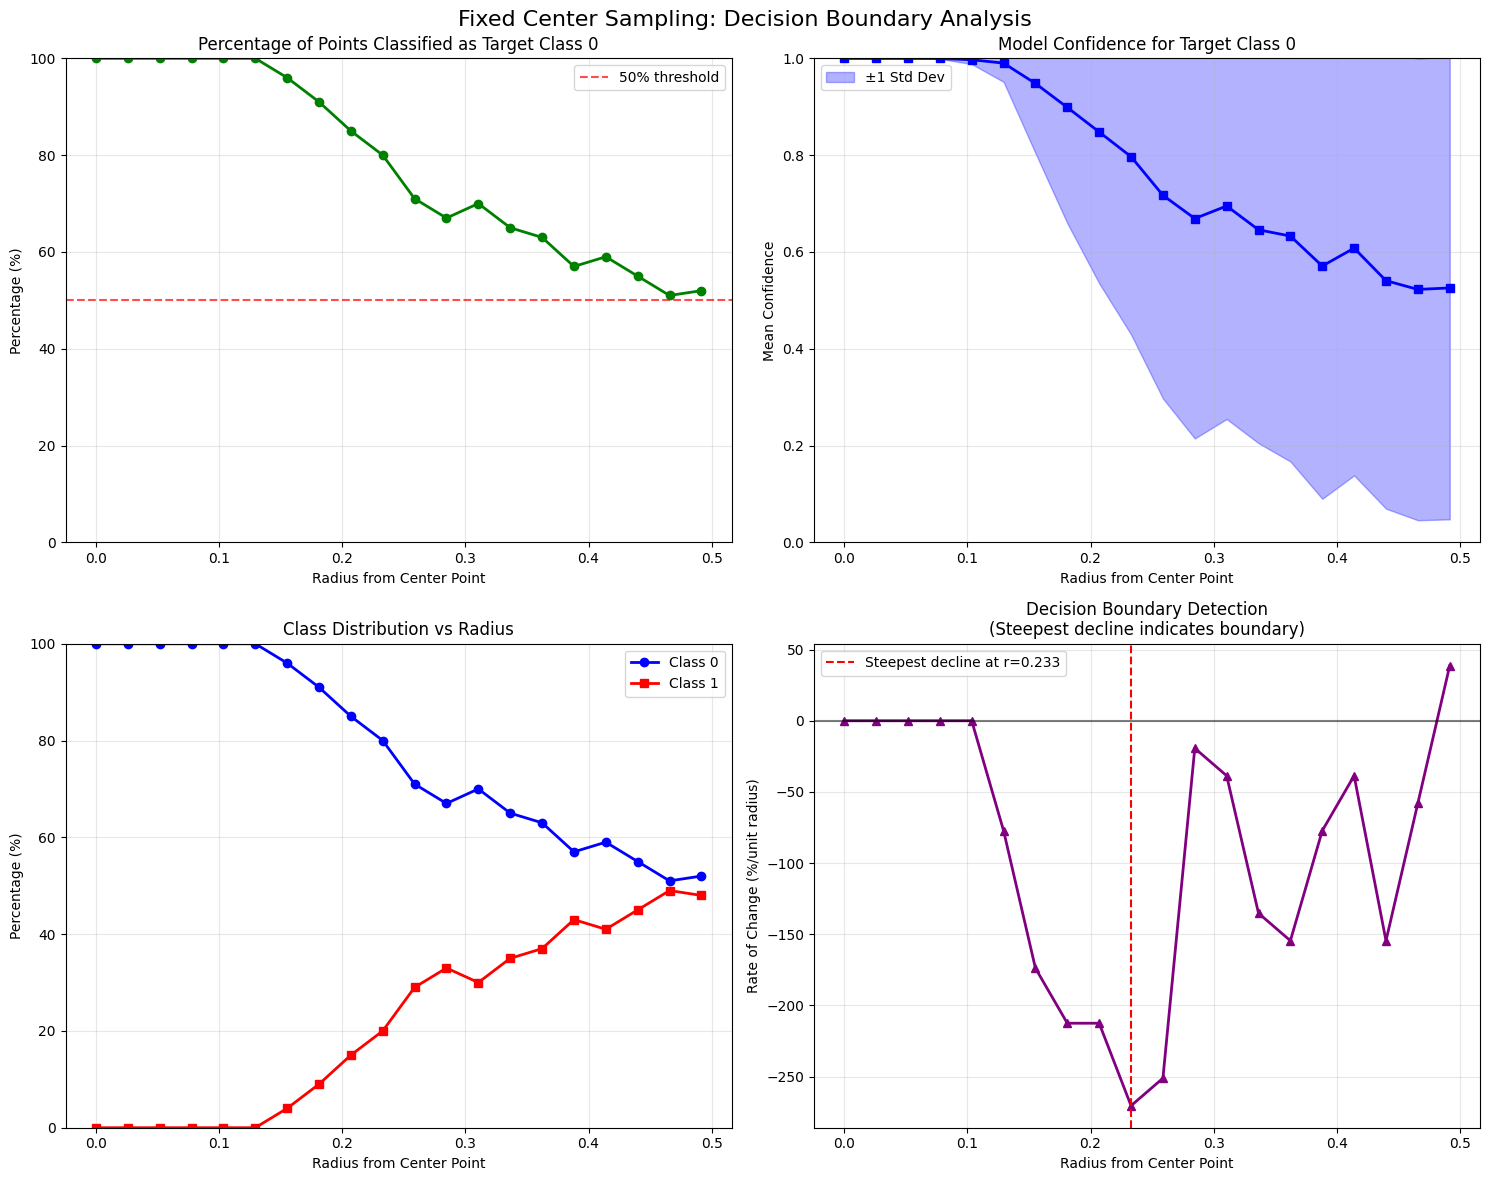


Analysis Results:
Target class: 0
Distance to found boundary: 0.492
Radius with steepest decline: 0.233
Ratio (steepest/boundary): 0.474
✓ There appears to be a closer, better decision boundary!


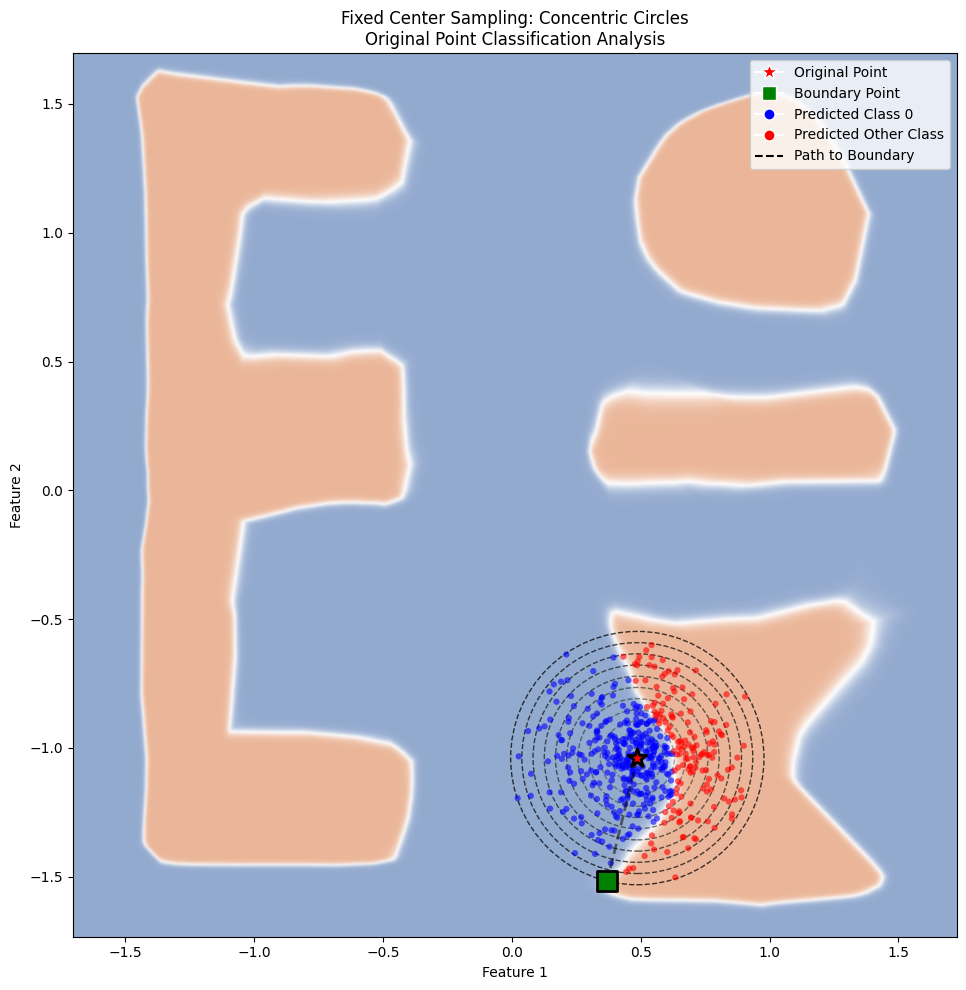

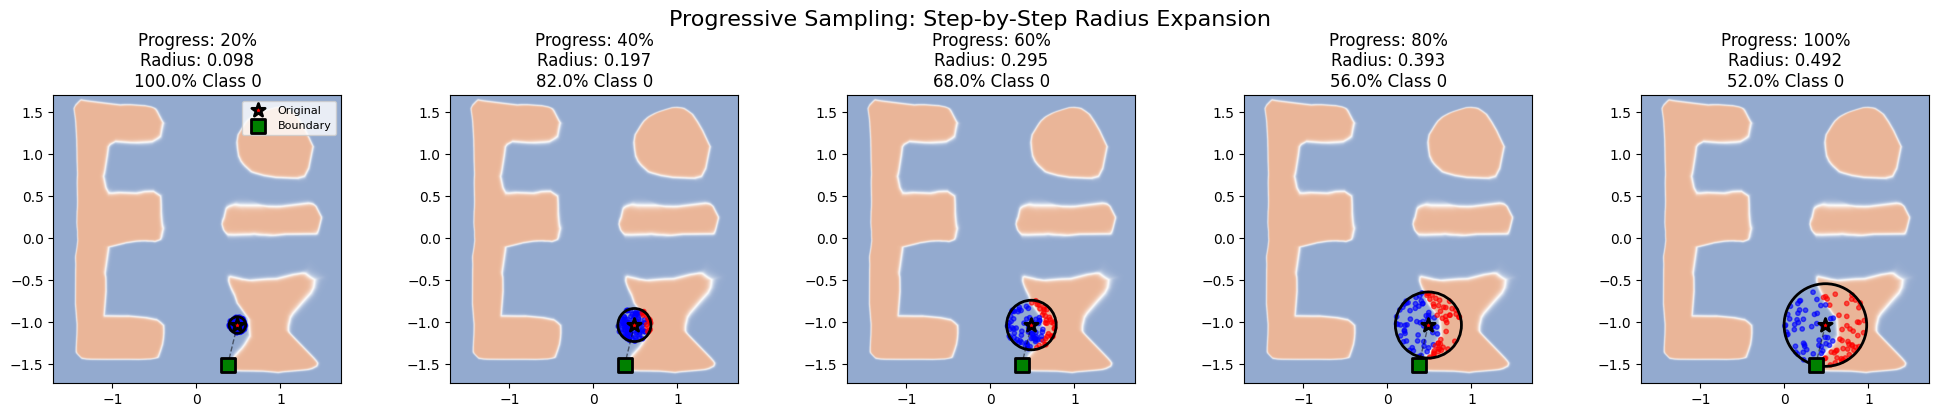

In [ ]:
sample_point = X_test[np.random.randint(0, len(X_test))]
sample_tensor = torch.tensor(sample_point, dtype=torch.float32)

random.seed(12)

# Define inference function for CMAES
inference_fn = lambda x: model.predict_probas(x)

# Run CMA-ES to find a confusing baseline
cma_baseline_np, cma_pred = cmaes_baseline(
    inference_fn=inference_fn,
    n_dims=sample_point.shape[0],
    n_classes=2,
    initial_baseline=sample_point,
    criterion=lambda f, x, _: combined_cma_cost(f, x, original_point, n_classes),
    std=0.5,
    n_generations=300
)

# Convert baseline to tensor
cma_baseline_tensor = torch.tensor(cma_baseline_np, dtype=torch.float32)


def sample_points_in_radius_fixed_center(center_point, radius, n_samples=100, n_dims=2):
    """
    Sample points uniformly within a sphere of given radius around fixed center point.
    """
    if radius == 0:
        return np.repeat(center_point.reshape(1, -1), n_samples, axis=0)

    # Generate random points in unit sphere
    normal = np.random.randn(n_samples, n_dims)
    normal = normal / np.linalg.norm(normal, axis=1, keepdims=True)

    # Random radius with proper distribution for uniform sampling in circle
    u = np.random.uniform(0, 1, n_samples)
    r = radius * (u ** (1.0 / n_dims))

    # Scale points by radius
    points = normal * r.reshape(-1, 1)

    # Translate to center
    sampled_points = points + center_point
    return sampled_points

def analyze_fixed_center_sampling(model, center_point, max_radius,
                                n_radius_steps=20, n_samples_per_radius=100,
                                target_class=None):
    """
    Analyze model predictions for points sampled around a fixed center with increasing radius.

    Args:
        model: Trained PyTorch model
        center_point: Fixed center point for sampling (numpy array)
        max_radius: Maximum radius to sample up to
        n_radius_steps: Number of radius steps
        n_samples_per_radius: Number of samples per radius
        target_class: Target class to analyze (if None, uses model's prediction for center)

    Returns:
        Dictionary containing analysis results
    """
    center_point = np.array(center_point)

    # Create radius steps (including 0)
    radii = np.linspace(0, max_radius, n_radius_steps)

    # Get target class if not specified
    if target_class is None:
        with torch.no_grad():
            center_tensor = torch.tensor(center_point.reshape(1, -1), dtype=torch.float32)
            pred = model(center_tensor)
            target_class = torch.argmax(pred, dim=1).item()

    # Store results
    results = {
        'radii': radii,
        'class_percentages': [],  # Percentage of points predicted as target class
        'confidence_means': [],   # Mean confidence for target class
        'confidence_stds': [],    # Std confidence for target class
        'all_predictions': [],    # All predictions for each radius
        'all_confidences': [],    # All confidences for each radius
        'sampled_points': []      # All sampled points for each radius
    }

    for radius in tqdm(radii, desc="Analyzing radius steps"):
        if radius == 0:
            # Special case for radius 0 - just the center point
            sampled_points = center_point.reshape(1, -1)
        else:
            # Sample points around center
            sampled_points = sample_points_in_radius_fixed_center(
                center_point, radius, n_samples_per_radius)

        # Get model predictions
        with torch.no_grad():
            sampled_tensor = torch.tensor(sampled_points, dtype=torch.float32)
            predictions = model(sampled_tensor)
            probs = torch.softmax(predictions, dim=1)

            # Get predicted classes
            predicted_classes = torch.argmax(predictions, dim=1).cpu().numpy()

            # Get confidence for target class
            target_confidences = probs[:, target_class].cpu().numpy()

        # Calculate statistics
        class_percentage = np.mean(predicted_classes == target_class) * 100  # Convert to percentage
        confidence_mean = np.mean(target_confidences)
        confidence_std = np.std(target_confidences)

        # Store results
        results['class_percentages'].append(class_percentage)
        results['confidence_means'].append(confidence_mean)
        results['confidence_stds'].append(confidence_std)
        results['all_predictions'].append(predicted_classes)
        results['all_confidences'].append(target_confidences)
        results['sampled_points'].append(sampled_points)

    # Convert to arrays
    results['class_percentages'] = np.array(results['class_percentages'])
    results['confidence_means'] = np.array(results['confidence_means'])
    results['confidence_stds'] = np.array(results['confidence_stds'])

    return results, target_class

def plot_fixed_center_analysis(results, target_class, center_point,
                              title="Fixed Center Sampling Analysis"):
    """
    Create visualization of fixed center sampling analysis.
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    radii = results['radii']

    # 1. Class percentage vs radius
    ax1 = axes[0, 0]
    ax1.plot(radii, results['class_percentages'], 'g-', linewidth=2, marker='o')
    ax1.set_xlabel('Radius from Center Point')
    ax1.set_ylabel('Percentage (%)')
    ax1.set_title(f'Percentage of Points Classified as Target Class {target_class}')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 100])
    ax1.axhline(y=50, color='red', linestyle='--', alpha=0.7, label='50% threshold')
    ax1.legend()

    # 2. Confidence vs radius
    ax2 = axes[0, 1]
    ax2.plot(radii, results['confidence_means'], 'b-', linewidth=2, marker='s')
    ax2.fill_between(radii,
                     results['confidence_means'] - results['confidence_stds'],
                     results['confidence_means'] + results['confidence_stds'],
                     alpha=0.3, color='blue', label='±1 Std Dev')
    ax2.set_xlabel('Radius from Center Point')
    ax2.set_ylabel('Mean Confidence')
    ax2.set_title(f'Model Confidence for Target Class {target_class}')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([0, 1])
    ax2.legend()

    # 3. Distribution heatmap
    ax3 = axes[1, 0]
    # Create classification distribution over radius
    class_0_percentages = []
    class_1_percentages = []

    for predictions in results['all_predictions']:
        class_0_pct = np.mean(predictions == 0) * 100
        class_1_pct = np.mean(predictions == 1) * 100
        class_0_percentages.append(class_0_pct)
        class_1_percentages.append(class_1_pct)

    ax3.plot(radii, class_0_percentages, 'b-', linewidth=2, label='Class 0', marker='o')
    ax3.plot(radii, class_1_percentages, 'r-', linewidth=2, label='Class 1', marker='s')
    ax3.set_xlabel('Radius from Center Point')
    ax3.set_ylabel('Percentage (%)')
    ax3.set_title('Class Distribution vs Radius')
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim([0, 100])
    ax3.legend()

    # 4. Decision boundary detection
    ax4 = axes[1, 1]
    # Calculate rate of change in class percentage
    class_pct = results['class_percentages']
    rate_of_change = np.gradient(class_pct, radii)

    ax4.plot(radii, rate_of_change, 'purple', linewidth=2, marker='^')
    ax4.set_xlabel('Radius from Center Point')
    ax4.set_ylabel('Rate of Change (%/unit radius)')
    ax4.set_title('Decision Boundary Detection\n(Steepest decline indicates boundary)')
    ax4.grid(True, alpha=0.3)
    ax4.axhline(y=0, color='black', linestyle='-', alpha=0.5)

    # Find the radius with steepest decline
    steepest_decline_idx = np.argmin(rate_of_change)
    steepest_radius = radii[steepest_decline_idx]
    ax4.axvline(x=steepest_radius, color='red', linestyle='--',
                label=f'Steepest decline at r={steepest_radius:.3f}')
    ax4.legend()

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

    return steepest_radius

def create_fixed_center_visualization(model, center_point, boundary_point, max_radius,
                                    n_circles=10, n_samples_per_circle=100,
                                    smoothed_colors=None, x_min=None, x_max=None,
                                    y_min=None, y_max=None):
    """
    Create visualization showing concentric circles around fixed center point.
    """
    # Create radius steps
    radii = np.linspace(0.1, max_radius, n_circles)  # Start from 0.1 to avoid empty circle

    # Get target class
    with torch.no_grad():
        center_tensor = torch.tensor(center_point.reshape(1, -1), dtype=torch.float32)
        pred = model(center_tensor)
        target_class = torch.argmax(pred, dim=1).item()

    fig, ax = plt.subplots(figsize=(10, 10))

    # Show background if provided
    if smoothed_colors is not None:
        ax.imshow(smoothed_colors, extent=(x_min, x_max, y_min, y_max),
                 origin='lower', alpha=0.6)

    # Draw circles and sample points
    for i, radius in enumerate(radii):
        # Draw circle
        circle = plt.Circle(center_point, radius, fill=False,
                           color='black', linestyle='--', linewidth=1,
                           alpha=0.3 + 0.5 * (i / len(radii)))
        ax.add_patch(circle)

        # Sample points
        sampled_points = sample_points_in_radius_fixed_center(
            center_point, radius, n_samples_per_circle)

        # Get predictions
        with torch.no_grad():
            points_tensor = torch.tensor(sampled_points, dtype=torch.float32)
            predictions = model(points_tensor)
            predicted_classes = torch.argmax(predictions, dim=1).cpu().numpy()
            probs = torch.softmax(predictions, dim=1)
            confidences = probs[:, target_class].cpu().numpy()

        # Plot points colored by class prediction
        colors = ['blue' if c == target_class else 'red' for c in predicted_classes]
        scatter = ax.scatter(sampled_points[:, 0], sampled_points[:, 1],
                           c=colors, s=20, alpha=0.6, edgecolors='none')

    # Mark important points
    ax.scatter(*center_point, c='red', s=200, marker='*',
              edgecolors='black', linewidth=2, label='Original Point', zorder=10)
    ax.scatter(*boundary_point, c='green', s=200, marker='s',
              edgecolors='black', linewidth=2, label='Boundary Point', zorder=10)

    # Draw line from center to boundary
    ax.plot([center_point[0], boundary_point[0]],
            [center_point[1], boundary_point[1]],
            'k--', alpha=0.5, linewidth=2, label='Path to Boundary')

    # Labels and title
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_title(f'Fixed Center Sampling: Concentric Circles\nOriginal Point Classification Analysis')

    # Custom legend
    legend_elements = [
        Line2D([0], [0], marker='*', color='w', markerfacecolor='red',
               markersize=12, label='Original Point'),
        Line2D([0], [0], marker='s', color='w', markerfacecolor='green',
               markersize=10, label='Boundary Point'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='blue',
               markersize=8, label=f'Predicted Class {target_class}'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red',
               markersize=8, label=f'Predicted Other Class'),
        Line2D([0], [0], color='black', linestyle='--', label='Path to Boundary')
    ]
    ax.legend(handles=legend_elements, loc='best')

    # Set limits
    if x_min is not None:
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

    ax.set_aspect('equal')
    plt.tight_layout()
    plt.show()

def visualize_progressive_sampling(model, center_point, boundary_point, max_radius,
                                  sample_radii=[0.2, 0.4, 0.6, 0.8, 1.0], n_samples=100,
                                  smoothed_colors=None, x_min=None, x_max=None,
                                  y_min=None, y_max=None):
    """
    Create step-by-step visualization showing progressive radius expansion.
    """
    # Convert relative radii to actual radii
    actual_radii = [r * max_radius for r in sample_radii]

    # Get target class
    with torch.no_grad():
        center_tensor = torch.tensor(center_point.reshape(1, -1), dtype=torch.float32)
        pred = model(center_tensor)
        target_class = torch.argmax(pred, dim=1).item()

    fig, axes = plt.subplots(1, len(actual_radii), figsize=(4*len(actual_radii), 4))
    if len(actual_radii) == 1:
        axes = [axes]

    for idx, (ax, radius) in enumerate(zip(axes, actual_radii)):
        # Show background
        if smoothed_colors is not None:
            ax.imshow(smoothed_colors, extent=(x_min, x_max, y_min, y_max),
                     origin='lower', alpha=0.6)

        # Sample points
        sampled_points = sample_points_in_radius_fixed_center(center_point, radius, n_samples)

        # Get predictions
        with torch.no_grad():
            points_tensor = torch.tensor(sampled_points, dtype=torch.float32)
            predictions = model(points_tensor)
            predicted_classes = torch.argmax(predictions, dim=1).cpu().numpy()

        # Plot sampled points
        colors = ['blue' if c == target_class else 'red' for c in predicted_classes]
        ax.scatter(sampled_points[:, 0], sampled_points[:, 1], c=colors, s=10, alpha=0.6)

        # Draw current circle
        circle = plt.Circle(center_point, radius, fill=False, color='black',
                           linestyle='-', linewidth=2)
        ax.add_patch(circle)

        # Mark important points
        ax.scatter(*center_point, c='red', s=100, marker='*',
                  edgecolors='black', linewidth=2, label='Original', zorder=5)
        ax.scatter(*boundary_point, c='green', s=100, marker='s',
                  edgecolors='black', linewidth=2, label='Boundary', zorder=5)

        # Draw path line
        ax.plot([center_point[0], boundary_point[0]],
                [center_point[1], boundary_point[1]],
                'k--', alpha=0.5, linewidth=1)

        # Calculate percentage
        class_percentage = np.mean(predicted_classes == target_class) * 100

        # Set title
        progress = sample_radii[idx] * 100
        ax.set_title(f'Progress: {progress:.0f}%\nRadius: {radius:.3f}\n{class_percentage:.1f}% Class {target_class}')

        # Set limits
        if x_min is not None:
            ax.set_xlim(x_min, x_max)
            ax.set_ylim(y_min, y_max)

        if idx == 0:
            ax.legend(loc='best', fontsize=8)

    plt.suptitle('Progressive Sampling: Step-by-Step Radius Expansion', fontsize=16)
    plt.tight_layout()
    plt.show()

# Example usage:
# Calculate distance to boundary point as base radius
boundary_distance = np.linalg.norm(sample_point - cma_baseline_np)

# Make max radius larger (e.g., 1.5x or 2x the boundary distance)
max_distance = boundary_distance * 1  # You can adjust this multiplier

print(f"Boundary distance: {boundary_distance:.3f}")
print(f"Using max radius: {max_distance:.3f} (extended by factor of 1.8)")

# Run the fixed center analysis
results, target_class = analyze_fixed_center_sampling(
    model=model,
    center_point=sample_point,  # Use original sample point as fixed center
    max_radius=max_distance,
    n_radius_steps=20,
    n_samples_per_radius=100
)

# Plot the analysis
steepest_radius = plot_fixed_center_analysis(
    results, target_class, sample_point,
    title="Fixed Center Sampling: Decision Boundary Analysis"
)

print(f"\nAnalysis Results:")
print(f"Target class: {target_class}")
print(f"Distance to found boundary: {max_distance:.3f}")
print(f"Radius with steepest decline: {steepest_radius:.3f}")
print(f"Ratio (steepest/boundary): {steepest_radius/max_distance:.3f}")

if steepest_radius < max_distance * 0.8:
    print("✓ There appears to be a closer, better decision boundary!")
else:
    print("→ The found boundary seems to be approximately correct.")

# Create the main visualization (concentric circles)
create_fixed_center_visualization(
    model=model,
    center_point=sample_point,
    boundary_point=cma_baseline_np,  # Add boundary point
    max_radius=max_distance,
    n_circles=10,
    n_samples_per_circle=50,
    smoothed_colors=smoothed_colors,
    x_min=x_min, x_max=x_max,
    y_min=y_min, y_max=y_max
)

# Create the progressive sampling visualization
visualize_progressive_sampling(
    model=model,
    center_point=sample_point,
    boundary_point=cma_baseline_np,
    max_radius=max_distance,
    sample_radii=[0.2, 0.4, 0.6, 0.8, 1.0],  # 20%, 40%, 60%, 80%, 100%
    n_samples=100,
    smoothed_colors=smoothed_colors,
    x_min=x_min, x_max=x_max,
    y_min=y_min, y_max=y_max
)

## Create multiclass synthetic dataset

In [ ]:
! pip install -U drawdata

In [ ]:
from drawdata import ScatterWidget

widget = ScatterWidget()
widget

ScatterWidget()

In [ ]:
data_multiclass = widget.data_as_pandas

In [ ]:
data_multiclass.to_csv("multiclass_2d_dataset.csv", index=False)

In [ ]:
len(data_multiclass)

1449

In [ ]:
# encode classes
from sklearn.preprocessing import StandardScaler, LabelEncoder

le = LabelEncoder()
y_all = le.fit_transform(data_multiclass['label'])  # Now 0,1,2
X_all = data_multiclass.drop(columns=['label']).values

In [ ]:
data_multiclass = data_multiclass[['x', 'y', 'label']]

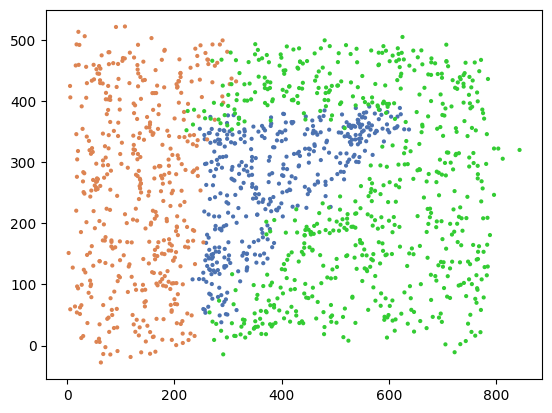

In [ ]:
_colors=[(0.298, 0.447, 0.690),(0.867, 0.518, 0.322), (0.2, 0.8, 0.2)]
plt.scatter(X_all[:,0], X_all[:, 1], c=[_colors[int(i)] for i in y_all], s=4)
plt.show()

In [ ]:
n_classes = len(np.unique(y_all))
n_classes

3

Using device: cpu
Epoch 0/100, Train Loss: 0.9609, Val Loss: 0.7856
Epoch 50/100, Train Loss: 0.1075, Val Loss: 0.1336
Final Epoch 100, Train Loss: 0.1001, Val Loss: 0.1343


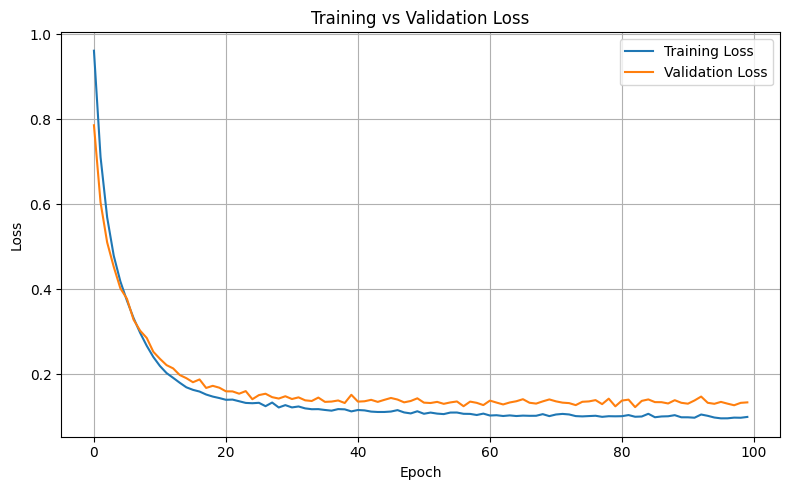

In [ ]:
# Split into train + val first, then extract test
X_temp, X_test, y_temp, y_test = train_test_split(X_all, y_all, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)  # 72% train, 18% val, 10% test

# Standardize using training set
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_all = scaler.transform(X_all)

# Train the model with validation tracking
model_multiclass, train_losses, val_losses = train_model(X_train, y_train, X_val, y_val, n_classes=3, epochs=100)

# Plot the losses
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
x_min, y_min = X_all.min(axis=0)
x_max, y_max = X_all.max(axis=0)
num_points = 1000

# Create linspace for x and y dimensions
x_grid = np.linspace(x_min, x_max, num_points)
y_grid = np.linspace(y_min, y_max, num_points)

# Create a meshgrid (grid of points in the x-y plane)
xx, yy = np.meshgrid(x_grid, y_grid)
grid_points_multiclass = np.c_[xx.ravel(), yy.ravel()]

In [ ]:
grid_probas_multiclass = model_multiclass.predict_probas(grid_points_multiclass).detach().numpy()

grid_labels_multiclass = model_multiclass.predict(grid_points_multiclass)
grid_alphas_multiclass = grid_probas_multiclass[np.arange(len(grid_probas_multiclass)), np.expand_dims(grid_labels_multiclass, 0)].squeeze()
grid_alphas_multiclass.shape

(1000000,)

In [ ]:
grid_labels_multiclass.unique()

tensor([0, 1, 2])

In [ ]:
grid_labels_reshaped_multiclass = grid_labels_multiclass.reshape(num_points, num_points)
grid_alphas_reshaped_multiclass = grid_alphas_multiclass.reshape(num_points, num_points)
colors = np.zeros((num_points, num_points, 4))
colors[grid_labels_reshaped_multiclass == 0] = [0.298, 0.447, 0.690, 1]
colors[grid_labels_reshaped_multiclass == 1] = [0.867, 0.518, 0.322, 1]
colors[grid_labels_reshaped_multiclass == 2] = [0.2, 0.8, 0.2, 1]

colors[..., -1] = 2 * (grid_alphas_reshaped_multiclass - np.min(grid_alphas_reshaped_multiclass))
smoothed_colors = gaussian_filter(colors, sigma=[1, 1, 0])


colors normalized to min probability, ie white == 0.33446088433265686 'certainty';


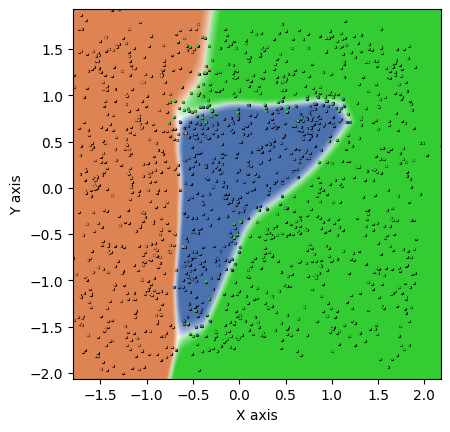

In [ ]:
fig, ax = plt.subplots()
ax.imshow(smoothed_colors, extent=(x_min, x_max, y_min, y_max), origin='lower')

# plot full dataset with original label; add small black outline
ax.scatter(X_all[:, 0], X_all[:, 1], s=1.75, c='black')
ax.scatter(X_all[:, 0], X_all[:, 1], s=1, c=[_colors[int(i)] for i in y_all])

plt.xlabel('X axis')
plt.ylabel('Y axis')
print(f"colors normalized to min probability, ie white == {np.min(grid_alphas_reshaped_multiclass)} 'certainty';")

plt.show()

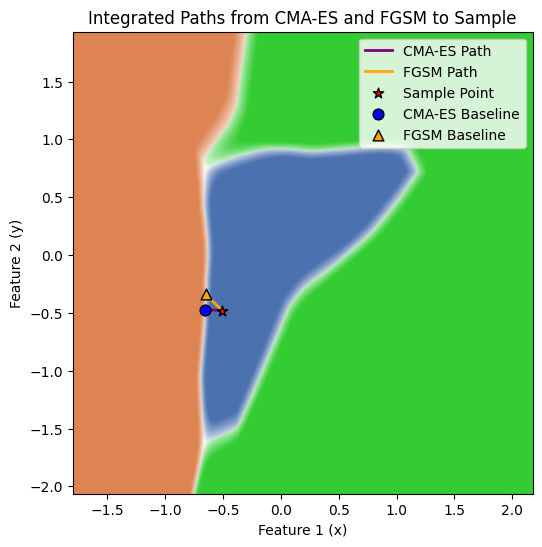

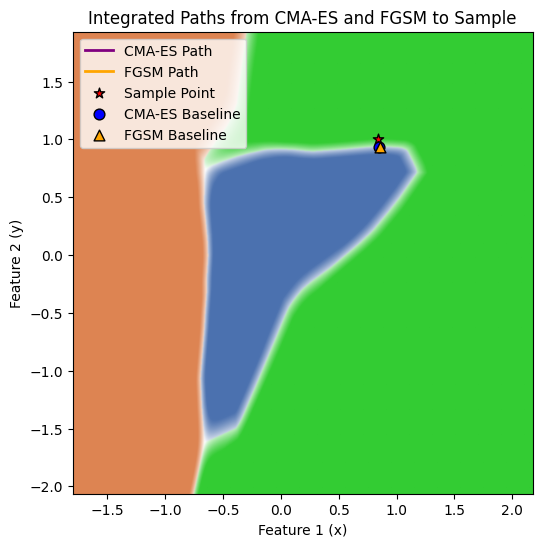

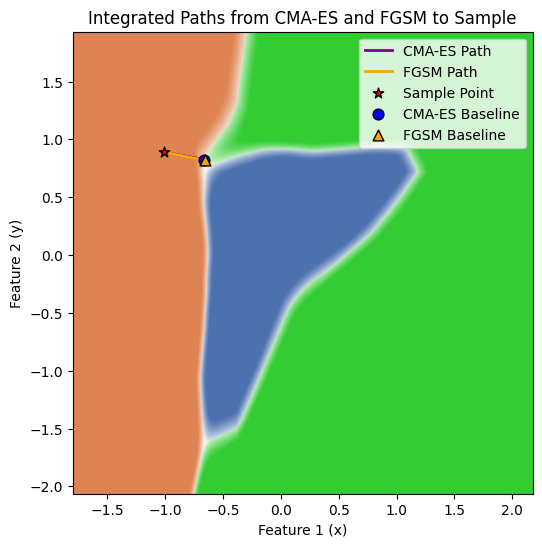

In [ ]:
n_test = 3

test_point_indexes = [np.random.randint(0, len(X_test)) for _ in range(n_test)]
for index in test_point_indexes:
    run_analysis(
        model_multiclass,
        n_dims = 2,
        n_classes = 3,
        original_point=X_test[index],  # sample from multiclass data
        alpha=0.5,
        beta=0.5
    )


## Calculate evaluation metrics for multiclass 2D synthehic dataset

In [ ]:
n_samples = 100
distances_cmaes = []
distances_fgsm = []
distances_cmaes_sample = []
distances_fgsm_sample = []
uniformity_cmaes = []
uniformity_fgsm = []
n_classes = 3

for _ in range(n_samples):
    # --- 1. Generate a random sample ---
    idx = np.random.randint(0, X_test.shape[0])
    original_point = X_test[idx]

    # --- 2. Find ground truth boundary ---
    ground_truth = find_closest_boundary(
        original_point, smoothed_colors, x_min, x_max, y_min, y_max
    )

    # --- 3. CMA-ES solution ---
    solution_cmaes, pred_cmaes = cmaes_baseline(
        inference_fn=inference_fn,
        n_dims=original_point.shape[0],
        n_classes=n_classes,
        initial_baseline=original_point,
        criterion=lambda f, x, _: combined_cma_cost(f, x, original_point, n_classes),
        n_generations=300
    )

    # --- 4. FGSM solution ---
    fgsm_solution = fgsm_decision_boundary_point(
        model=model,
        original_point=original_point,
        n_classes=n_classes,
        epsilon=0.01,
        n_steps=100
    )

    # --- 5. Compute Euclidean distances to ground truth ---
    dist_cmaes = np.linalg.norm(solution_cmaes - ground_truth)
    dist_fgsm = np.linalg.norm(fgsm_solution - ground_truth)
    distances_cmaes.append(dist_cmaes)
    distances_fgsm.append(dist_fgsm)

    # --- 6. Compute uniformity scores ---
    # CMA-ES
    y_cmaes = inference_fn(torch.tensor(solution_cmaes, dtype=torch.float)).detach().cpu().numpy()
    uniformity_cmaes.append(get_uniformity_score(y_cmaes))

    # FGSM
    y_fgsm = inference_fn(torch.tensor(fgsm_solution, dtype=torch.float)).detach().cpu().numpy()
    uniformity_fgsm.append(get_uniformity_score(y_fgsm))

    # --- 7. Compute Euclidean distances to original point ---
    dist_cmaes = np.linalg.norm(solution_cmaes - original_point)
    dist_fgsm = np.linalg.norm(fgsm_solution - original_point)
    distances_cmaes_sample.append(dist_cmaes)
    distances_fgsm_sample.append(dist_fgsm)

# --- Summary ---
print("Average Euclidean distance to ground truth:")
print("CMA-ES:", np.mean(distances_cmaes))
print("FGSM:", np.mean(distances_fgsm))

print("Standart Deviation Euclidean distance to ground truth:")
print("CMA-ES:", np.std(distances_cmaes))
print("FGSM:", np.std(distances_fgsm))

print("----------------------------------------------------------------------")

print("Average uniformity loss:")
print("CMA-ES:", np.mean(uniformity_cmaes))
print("FGSM:", np.mean(uniformity_fgsm))

print("Standart Deviation uniformity loss:")
print("CMA-ES:", np.std(uniformity_cmaes))
print("FGSM:", np.std(uniformity_fgsm))



print("----------------------------------------------------------------------")

print("Average Euclidean distance to sample point:")
print("CMA-ES:", np.mean(distances_cmaes_sample))
print("FGSM:", np.mean(distances_fgsm_sample))

print("Standart Deviation Euclidean distance to sample point:")
print("CMA-ES:", np.std(distances_cmaes_sample))
print("FGSM:", np.std(distances_fgsm_sample))


Average Euclidean distance to ground truth:
CMA-ES: 0.3986219854685346
FGSM: 0.412064690670165
Standart Deviation Euclidean distance to ground truth:
CMA-ES: 0.25066719122149994
FGSM: 0.22576131609313374
----------------------------------------------------------------------
Average uniformity loss:
CMA-ES: 0.16050163
FGSM: 0.31293124
Standart Deviation uniformity loss:
CMA-ES: 0.31233865
FGSM: 0.22861919
----------------------------------------------------------------------
Average Euclidean distance to sample point:
CMA-ES: 0.17896597771950415
FGSM: 0.2133638389890212
Standart Deviation Euclidean distance to sample point:
CMA-ES: 0.14384147526269353
FGSM: 0.12375699162240002
